In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef

In [81]:
X_train=pd.read_csv('X_train2.csv',index_col=[0])
Y_train=pd.read_csv('Y_train2.csv',index_col=[0])
X_test=pd.read_csv('X_test2.csv',index_col=[0])
Y_test=pd.read_csv('Y_test2.csv',index_col=[0])

In [27]:
Y_train.shape

(472432, 1)

In [34]:
##selecting features based on mutual information(univariate analysis)
select_k = 20
selection = SelectKBest(mutual_info_classif, k=select_k).fit(X_train, Y_train.values.ravel())
X_trainfilter = X_train.columns[selection.get_support()]
print(X_trainfilter)

Index(['ProductCD', 'card6', 'addr2', 'D7', 'D8', 'V202', 'V203', 'V263',
       'V264', 'V331', 'id_03', 'id_07', 'id_14', 'id_16', 'id_18', 'id_35',
       'id_38', 'Logcard3', 'OS_id_30', 'device_name'],
      dtype='object')


In [35]:
X_trainfiltered=selection.transform(X_train)
X_testfiltered=selection.transform(X_test)

In [36]:
X_trainfiltered=pd.DataFrame(X_trainfiltered)
X_testfiltered=pd.DataFrame(X_testfiltered)

In [37]:
X_testfiltered.shape,Y_test.shape

((118108, 20), (118108, 1))

In [38]:
trainfilter=pd.concat([Y_train,X_trainfiltered],axis=1)

In [39]:
trainfilter.shape

(472432, 21)

In [40]:
##resampling of training set (SMOTE and Random Undersampling)
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2),
    RandomUnderSampler(sampling_strategy=0.9)           
)

In [41]:
X_trainfiltered.var()
Y_train.var()

isFraud    0.033901
dtype: float64

In [42]:
X_ftrain,Y_ftrain=pipe.fit_resample(X_trainfiltered,Y_train)

In [43]:
X_ftrain=pd.DataFrame(X_ftrain)
Y_ftrain=pd.DataFrame(Y_ftrain)

In [71]:
train_filter_=pd.concat([X_ftrain,Y_ftrain],axis=1)
# Shuffle dataframe rows
trainfilter = train_filter_.sample(frac=1, random_state=60)

In [72]:
X_filtertrain = trainfilter.drop('isFraud', axis=1)
Y_filtertrain=trainfilter['isFraud']

In [73]:
X_filtertest=X_testfiltered
Y_filtertest=Y_test

In [74]:
X_filtertrain.shape,Y_filtertrain.shape,X_filtertest.shape,Y_filtertest.shape

((192461, 20), (192461,), (118108, 20), (118108, 1))

In [48]:
#SGDClassifier

In [50]:
#first standardize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_filtertrain = sc.fit_transform(X_filtertrain)

X_filtertest = sc.fit_transform(X_filtertest)

In [51]:
#lets try with first default value
clf = SGDClassifier(loss="log")
clf.fit(X_filtertrain,Y_filtertrain)
y_trainpred=clf.predict_proba(X_filtertrain)
y_testpred = clf.predict_proba(X_filtertest)

In [52]:
#auc score with deafult value
print('train auc with default parameter:',roc_auc_score(Y_filtertrain,y_trainpred[:,1]))
print('test auc with default parameter:',roc_auc_score(Y_filtertest,y_testpred[:,1]))

train auc with default parameter: 0.7254896625067615
test auc with default parameter: 0.7225452008162617


In [53]:
#GridSearchCV with Timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 5)
time_splitter_inner = TimeSeriesSplit(n_splits = 5)

model = SGDClassifier(loss="log")
params = {
         'alpha':[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3],
         'penalty':['l1','l2']
         }

gs_SD = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)

In [54]:
gs_SD.fit(X_filtertrain,Y_filtertrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   11.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SGDClassifier(loss='log'), n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=10)

In [55]:
SDG_scores = cross_val_score(gs_SD,X_filtertrain,Y_filtertrain, cv = time_splitter_outer, scoring = 'roc_auc').mean()
print(SDG_scores)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1465s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1919s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    6.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    8.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


0.7272662945086459


In [82]:
# Best values of the hyperparameters
penalty_best = gs_SD.best_estimator_.penalty
alpha_best = gs_SD.best_estimator_.alpha

In [57]:
SGD = SGDClassifier(penalty=penalty_best,alpha = alpha_best,loss='log')
SGD.fit(X_filtertrain,Y_filtertrain)

SGDClassifier(alpha=0.01, loss='log')

In [58]:
#auc after parameter tuning
y_trainpredprobfiltersd=SGD.predict_proba(X_filtertrain)
y_testpredprobfiltersd =SGD.predict_proba(X_filtertest)
print('train auc:',roc_auc_score(Y_filtertrain,y_trainpredprobfiltersd[:,1]))
print('test auc:',roc_auc_score(Y_filtertest,y_testpredprobfiltersd[:,1]))

train auc: 0.7271318035329892
test auc: 0.7228187884970217


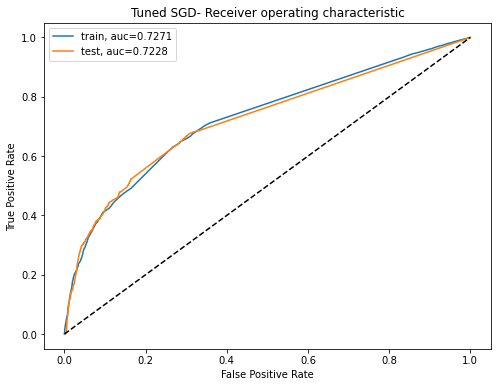

In [59]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_filtertrain,y_trainpredprobfiltersd[:,1])
auc = roc_auc_score(Y_filtertrain, y_trainpredprobfiltersd[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_filtertest,  y_testpredprobfiltersd[:,1])
auc = roc_auc_score(Y_filtertest,  y_testpredprobfiltersd [:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD- Receiver operating characteristic')
plt.show()

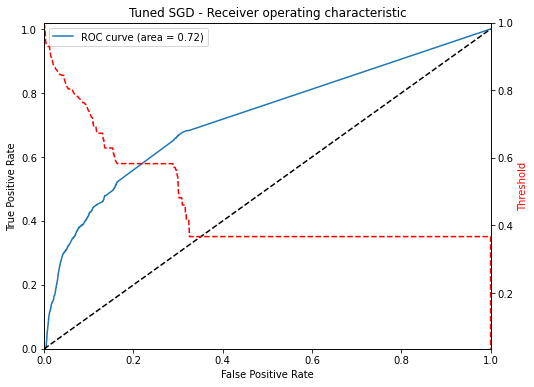

In [62]:
y_scores = y_testpredprobfiltersd [:,1]
fpr, tpr, thresholds = roc_curve(Y_filtertest, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [63]:
y_trainpredfiltersd=SGD.predict(X_filtertrain)
y_testpredfiltersd= SGD.predict(X_filtertest)

In [64]:
print("Accuracy:\n",metrics.accuracy_score(Y_filtertest,y_testpredfiltersd))
print("Recall:\n",metrics.recall_score(Y_filtertest,y_testpredfiltersd))

Accuracy:
 0.6982253530666848
Recall:
 0.6680610236220472


In [65]:
#Confusion Matrix 
cm_train = confusion_matrix(Y_filtertrain,y_trainpredfiltersd)
cm_test  =confusion_matrix(Y_filtertest,y_testpredfiltersd)

Text(0.5, 1.0, 'test')

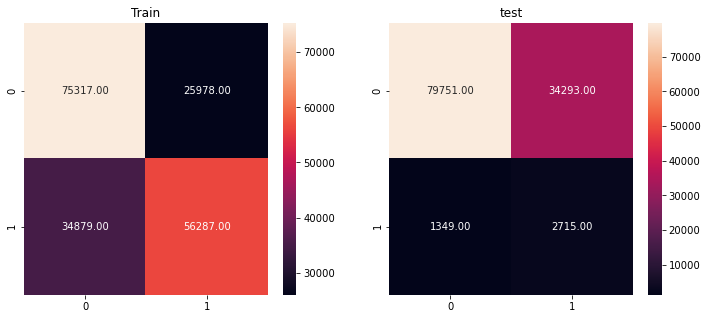

In [66]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,annot=True,fmt='.2f')
plt.title('Train')
plt.subplot(1,2,2)
sns.heatmap(cm_test,annot=True,fmt='.2f')
plt.title('test')

In [67]:
#matthews correlation coefficient
matthews_corrcoef(Y_filtertrain, y_trainpredfiltersd)
matthews_corrcoef(Y_filtertest, y_testpredfiltersd)

0.1443604513796723

In [68]:
#Random forest

In [76]:
# with default paramter
clf = RandomForestClassifier()
clf.fit(X_filtertrain,Y_filtertrain)
y_trainpred=clf.predict_proba(X_filtertrain)
y_testpred = clf.predict_proba(X_filtertest)

In [77]:
# auc with default parameters
print('train auc with default parameter:',roc_auc_score(Y_filtertrain,y_trainpred[:,1]))
print('test auc with default parameter:',roc_auc_score(Y_filtertest,y_testpred[:,1]))

train auc with default parameter: 0.866366779663897
test auc with default parameter: 0.6998163822562476


In [78]:
#GridSearchCV with timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 3)
time_splitter_inner = TimeSeriesSplit(n_splits = 3)

model=RandomForestClassifier()
params = {'n_estimators':[500,700,900,1000],
           'max_depth':[3,5,7,9,11,13]}

gs_rf = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)


In [79]:
gs_rf.fit(X_filtertrain,Y_filtertrain)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  9.0min remaining:   58.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 10.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'n_estimators': [500, 700, 900, 1000]},
             scoring='roc_auc', verbose=10)

In [80]:
forest_scores = cross_val_score(gs_rf, X_filtertrain,Y_filtertrain, cv = time_splitter_outer, scoring = 'roc_auc').mean()
print(forest_scores)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  2.0min remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.4min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  4.0min remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  4.8min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:  6.2min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  7.3min finished


0.8169336030738962


In [83]:
# Best values of the hyperparameters
max_depth_best = gs_rf.best_estimator_.max_depth
n_estimators_best = gs_rf.best_estimator_.n_estimators

In [84]:
rfc = RandomForestClassifier(max_depth = max_depth_best, n_estimators = n_estimators_best)
rfc.fit(X_filtertrain,Y_filtertrain)

RandomForestClassifier(max_depth=13, n_estimators=1000)

In [85]:
#auc score after parameter tuning 
y_trainpredrffilter=rfc.predict_proba(X_filtertrain)
y_testpredrffilter =rfc.predict_proba(X_filtertest)
print('train auc:',roc_auc_score(Y_filtertrain,y_trainpredrffilter[:,1]))
print('test auc:',roc_auc_score(Y_filtertest,y_testpredrffilter[:,1]))

train auc: 0.8280108334622307
test auc: 0.7390676465579523


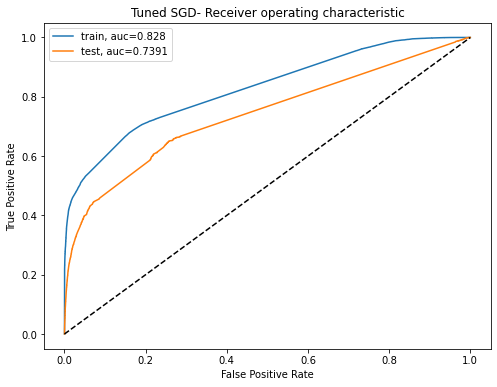

In [86]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_filtertrain,y_trainpredrffilter[:,1])
auc = roc_auc_score(Y_filtertrain, y_trainpredrffilter[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_filtertest,  y_testpredrffilter[:,1])
auc = roc_auc_score(Y_filtertest,  y_testpredrffilter [:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD- Receiver operating characteristic')
plt.show()

In [87]:
y_trainpred_=rfc.predict(X_filtertrain)
y_testpred_ = rfc.predict(X_filtertest)

In [88]:
print("Accuracy:\n",metrics.accuracy_score(Y_filtertest,y_testpred_))
print("Recall:\n",metrics.recall_score(Y_filtertest,y_testpred_))

Accuracy:
 0.7761455616893013
Recall:
 0.6003937007874016


In [89]:
#confusion matrix
cm_train = confusion_matrix(Y_filtertrain,y_trainpred_)
cm_test  =confusion_matrix(Y_filtertest,y_testpred_)

Text(0.5, 1.0, 'test')

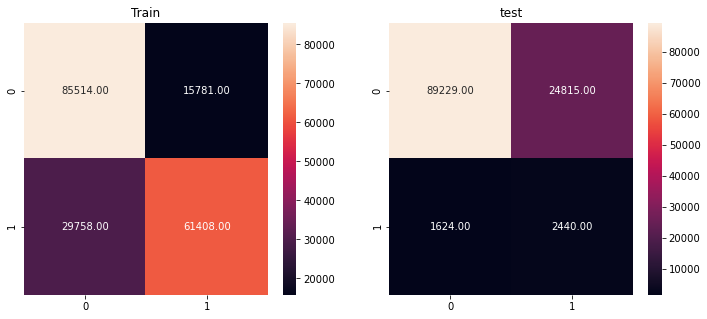

In [90]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,annot=True,fmt='.2f')
plt.title('Train')
plt.subplot(1,2,2)
sns.heatmap(cm_test,annot=True,fmt='.2f')
plt.title('test')

In [91]:
#matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(Y_filtertrain, y_trainpred_)
matthews_corrcoef(Y_filtertest, y_testpred_)

0.1656131497153814